<a href="https://colab.research.google.com/github/YahyaEryani/quantum-model/blob/main/notebooks/04_MLP_Training_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Training, Tuning, and Evaluation
 In this notebook, we will train a multilayer perceptron (MLP) model on the Higgs boson dataset we have preprocessed in the `01_data_exploration` notebook. We will perform the model training and tuning process to obtain the best model with the highest accuracy possible.

In [16]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.initializers import GlorotUniform
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt

## Loading Data

This code cell loads the training, validation, and test datasets that were saved in pickle format to the local directory.

In [14]:
# Mount Google Drive in Colab
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

# Load data from Google Drive
train_path = '/content/drive/MyDrive/Higgs_dataset/processed/training_data.pkl'
val_path   = '/content/drive/MyDrive/Higgs_dataset/processed/validation_data.pkl'
test_path  = '/content/drive/MyDrive/Higgs_dataset/processed/testing_data.pkl'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Prepare the data for training
This code separates the features and class labels from the train, validation, and test datasets.

In [8]:
# Separate features and labels
y_train = train_data['class_label']
X_train = train_data.drop('class_label', axis=1)
y_val = val_data['class_label']
X_val = val_data.drop('class_label', axis=1)
y_test = test_data['class_label']
X_test = test_data.drop('class_label', axis=1)

##Train the multilayer perceptron model
This code sets the hyperparameters for an MLP model, including the number of hidden layers, number of neurons per layer, activation functions, and dropout rates. It then trains the MLP model using the Adam optimizer with a specified learning rate, batch size, and number of epochs. Additionally, the model performance is monitored using the validation set during training.

In [9]:
# Define a learning rate schedule
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * np.exp(0.1 * (10 - epoch))

# Normalize the input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Define the model
model = Sequential()
model.add(Dense(1024, input_dim=28, activation='relu', kernel_initializer=GlorotUniform()))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu', kernel_initializer=GlorotUniform()))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_initializer=GlorotUniform()))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu', kernel_initializer=GlorotUniform()))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_initializer=GlorotUniform()))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Learning rate schedule callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_val, y_val), callbacks=[lr_scheduler, es])

Epoch 1/50
3282/3282 [==============================] - 184s 42ms/step - loss: 0.5910 - accuracy: 0.6823 - val_loss: 0.5463 - val_accuracy: 0.7177 - lr: 0.0010
Epoch 2/50
3282/3282 [==============================] - 138s 42ms/step - loss: 0.5488 - accuracy: 0.7173 - val_loss: 0.5306 - val_accuracy: 0.7293 - lr: 0.0010
Epoch 3/50
3282/3282 [==============================] - 138s 42ms/step - loss: 0.5378 - accuracy: 0.7250 - val_loss: 0.5234 - val_accuracy: 0.7345 - lr: 0.0010
Epoch 4/50
3282/3282 [==============================] - 134s 41ms/step - loss: 0.5289 - accuracy: 0.7309 - val_loss: 0.5157 - val_accuracy: 0.7392 - lr: 0.0010
Epoch 5/50
3282/3282 [==============================] - 134s 41ms/step - loss: 0.5230 - accuracy: 0.7356 - val_loss: 0.5090 - val_accuracy: 0.7430 - lr: 0.0010
Epoch 6/50
3282/3282 [==============================] - 136s 41ms/step - loss: 0.5170 - accuracy: 0.7394 - val_loss: 0.5070 - val_accuracy: 0.7454 - lr: 0.0010
Epoch 7/50
3282/3282 [==================

## Make predictions on the test data and evaluate the model performance
This code uses the Histogram Gradient Boosting Classifier model that was previously trained to make predictions on the test data.

In [13]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

test_pred = model.predict(X_test)
test_pred_binary = (test_pred >= 0.5).astype(int)
test_auc = roc_auc_score(y_test, test_pred)
test_f1 = f1_score(y_test, test_pred_binary)

print(f"Test AUC: {test_auc:.4f}")
print(f"Test F1 score: {test_f1:.4f}")

2813/2813 [==============================] - 13s 5ms/step - loss: 0.4864 - accuracy: 0.7614
Test loss: 0.4864
Test accuracy: 0.7614
2813/2813 [==============================] - 12s 4ms/step
Test AUC: 0.8443
Test F1 score: 0.7772


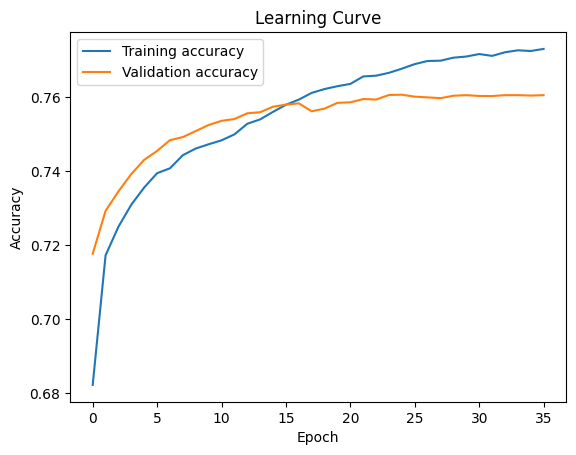

In [17]:
# Plot the learning curve
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
#Save the entire model to an H5 file
model.save("quantum_mlp_model.h5")